# DTSA 5510 Unsupervised Algorithms in Machine Learning Final Project

Location of this project: https://github.com/NikoKuu/unsupervised-algorithms-in-ml-final

## Project Topic ##
This work is the final project for DTSA 5510 Unsupervised Algorithms in Machine Learning course. The objective is to demonstrate how to use unsupervised learning methods, including data cleaning and eploratory data analysis (EDA). 

A dataset of Amazon webstore item descriptions by Pavlo Mospan was selected.
Kaggle is hosting the data set:

Amazon Advertisements, Pavlo Mospan 2019. 

Available at: https://www.kaggle.com/datasets/sachsene/amazons-advertisements/data. 

The plan is to clean up the data, perform basic Exploratory Data Analysis (EDA), vectorize the text descriptions of each item and use unsupervised learning methods to **categorize the data**. Non-negative Matrix Factorization and k-means are used as unsupervised learning algorithms. The actual categories of each item are known so the effectiveness of the unsupervised categorization can be gaged and supervised learning methods can also be used as a comparison to unsupervised.  


## Data ##
The data set consists of 525 csv-files (total of 280MB) in different levels of categories, totaling more than three million items with description. There are about 20 main categories and up to two additional nested categories. The main focus of this work is to cluster the items based on the description text mainly focusing on the most detailed category. 

Some of the text descriptions are very short and frankly impossible to categorize, such as a one-word text of the product part number. The text data also has a lot of numerical values for product dimensions or package quantity. A few methods to handle the numerical values were experimented. 

Each csv-file has only column named 'ad' and the first row is the header. Rest of the rows are item description text each item in the category. Category name is extracted from the filename. These files have csv file extensions but they should not treated such since some of the text have commas in them. 

#### Load most of the required modules

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import string

import keras
import tensorflow as tf
from keras import layers

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, RocCurveDisplay, roc_auc_score
%matplotlib inline

#### Note on the number of categories

Accuracy measurement will be conducted to verify the performance of the model(s). However, large number of categories makes label permutation to find optimal labels infeasible. 

$permutations = \frac{n!}{(n-r)!}$, where n is the total number of elements and r is the number of elements chosen.

In this work, $n=r$, and if we had $n=20$, we would have $20!\approx2.43e18$ permutations.

## Data Cleaning ##

The default categorization is cleaned by making the following changes and corrections:
* Move items in "home kitchen" category to main category "home" and subcategory "kitchen".
    * There already were some items in the home/kitchen -category.
* Move items in main category industrial/scientific category to common main category "industrial scientific".
    * There already were items in the "industrial scientific" -category.
* "Computers" moved under "electronics" main category
* "Smart home" moved under "electronics" main category
* Fix typo in 'sports'
    * No effect on the categories

Also, measurement units (such as inch, mm and pack), digits and puncuation are removed. The code below also does additional cleaning however some of it is not necessary since the TFIDF vectorizer can do it. 

#### Loading the data


In [87]:
class amz_data:
    def __init__(self):
        self.id = 0
        self.df = pd.DataFrame()
        self.df_cat = pd.DataFrame(columns=['full', 'main', 'sub', 'subsub', 'bottom'])
        self.placeholder = ''#'<NUM>'

    def read_data(self, basedir):
         # https://docs.python.org/3.9/library/os.html?highlight=os%20walk
        for root, dirs, files in os.walk(basedir):
            #print(files)
            for file in files:
                path = os.path.join(root, file)
                self.add_to_dataframe(path)

    def add_to_dataframe(self, path):
        # print(path)
        # Too long path name. Needed to add the prefix for long path names.
        with open(u'\\\\?\\' + os.path.abspath(path), 'r', encoding="utf8") as f:
            # lines = f.readlines()
            lines = f.read().splitlines() # without the \n in the end 
        df = pd.DataFrame(lines[1:], columns=['description'])
        df['id'] = self.id # Assign a unique id
        df['word_count'] = df.apply(self.count_words, axis=1)
        df['description'] = df.apply(self.preprocess_text, axis=1)
        categories = list(self.get_category(os.path.basename(path)))
        df['full'] = categories[0]
        df['main'] =  categories[1]
        df['sub'] =  categories[2]
        df['subsub'] =  categories[3]
        df['bottom'] =  categories[4]
        self.df = pd.concat([self.df, df], ignore_index=True)
        # self.df_cat = pd.concat([self.df_cat, [self.id, self.get_category(os.path.basename(path))]], ignore_index=True)
        self.df_cat.loc[len(self.df_cat)] = list(categories)
        self.id = self.id + 1
    
    def get_category(self, file_name):
        if 'home-kitchen' in file_name: # Home kitchen -exception
            file_name = file_name.replace('home-kitchen', 'home_kitchen')
        if 'industrial_scientific' in file_name: # Industrial scientific -exception
            file_name = file_name.replace('industrial_scientific-tests-measurements', 'industrial_scientific_tests-measurements')
            file_name = file_name.replace('industrial_scientific', 'industrial-scientific')
        if '_computers' in file_name: # Computers -exception
            file_name = file_name.replace('_computers', '_electronics_computers')
        if '_smart-home' in file_name: # Smart home -exception
            file_name = file_name.replace('_smart-home', '_electronics_smart-home')
        if 'fan-shop' in file_name: # Fan shop -correction
            file_name = file_name.replace('fan-shop', 'sports-outdoors_fan-shop')
        if 'aports' in file_name: # aports -correction
            file_name = file_name.replace('aports', 'sports')
        category = file_name.split('.')[0]
        cat_list = category.split('_')        
        main = cat_list[1]
        if len(cat_list) >= 4:
            sub = cat_list[2]
        else:
            sub = None
        if len(cat_list) >= 5:
            subsub = cat_list[3]
        else: 
            subsub = None
        bottom = cat_list[-1]
        return category.replace('amazon_',''), main, sub, subsub, bottom
    
    def count_words(self, row):
        words = len(row['description'].split(' '))
        return words
    
    def replace_numbers(self, row):
        text = re.sub(r'\d+', self.placeholder, row['description'])
        return text
    
    def replace_punct_digits(self, text):
        translator = str.maketrans('', '', string.punctuation + string.digits)
        return text.translate(translator)
    
    def replace_multispace(self, text):
        cleaned_text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
        return cleaned_text
    
    def replace_units(self, text):
        text = text.replace('mm','')
        text = text.replace('inches','')
        text = text.replace('inch','')
        text = text.replace('pack','')
        text = text.replace('pcs','')
        text = text.replace('pieces','')
        return text
        
    def preprocess_text(self, row):
        # Remove not helpful words
        text = row['description']
        text = text.lower()
        text = text.replace('|',' ')
        text = text.replace('/',' ')
        text = text.replace(' - ',', ')
        text = text.replace('-',' ')
        text = text.replace('"','')
        text = text.strip()
        pattern = r'\b[a-zA-Z]\b' # Replace single-character words 
        text = re.sub(pattern, '', text)
        # text = self.replace_punct_digits(text)
        text = self.replace_multispace(text)
        return text


Option 1. Load the data from local disk

In [67]:
amz = amz_data()
amz.read_data(r'..\Amazon Ads\data')

Option 2. Load the data from Kaggle

In [88]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sachsene/amazons-advertisements")

amz = amz_data()
amz.read_data(os.path.join(path, 'scrapped_data', 'scrapped_data'))
print(path)


C:\Users\nikok\.cache\kagglehub\datasets\sachsene\amazons-advertisements\versions\1


### Dataset info ###

General info and four first and last entries are printed out below to show the general format of the data. 

The dataframe has over three million rows. However, it was found that there are over 300,000 duplicated entries (identical rows). These duplicates had the same category. In addition to that, there are 600,000 duplicate descriptions with different category. Since the models are trying to categorize each item into one category, these multicategory entries are also removed. Total of ~950,000 items were removed as duplicates. 


In [89]:
print(amz.df.info(),'\n')
print(amz.df.head(4),'\n')
print(amz.df.tail(4),'\n')
print('\nNumber of nan values:\n', np.sum(amz.df.isna(), axis=0))
print('\nNumber of duplicated entries:', np.sum(amz.df.duplicated()))
print('Number of duplicated items:', np.sum(amz.df.duplicated(subset='description')))
print('Drop duplicates...')
amz.df.drop_duplicates(inplace=True, subset='description')
print('Number of duplicated items:', np.sum(amz.df.duplicated(subset='description')))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3318260 entries, 0 to 3318259
Data columns (total 8 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   description  object
 1   id           int64 
 2   word_count   int64 
 3   full         object
 4   main         object
 5   sub          object
 6   subsub       object
 7   bottom       object
dtypes: int64(2), object(6)
memory usage: 202.5+ MB
None 

                                         description  id  word_count  \
0  hisense 50 inch 4k ultra hd smart led tv 50h60...   0          10   
1  vizio 55 inches 4k ultra hd smart led tv p55 e...   0          11   
2  sony xbr49x900e series 49 class hdr uhd smart ...   0           8   
3  tivo bolt vox 1tb, dvr & streaming media playe...   0          17   

                     full         main   sub subsub      bottom  
0  electronics_smart-home  electronics  None   None  smart-home  
1  electronics_smart-home  electronics  None   None  smart-home  
2  electronics_smart

Total of 439 item level categories were found and those are grouped into 17 main categories.

In [90]:
print(amz.df_cat.info(), '\n')
print('Any duplicated categories:', np.any(amz.df_cat.duplicated()), '\n')
print('Number of full categories:', len(pd.unique(amz.df_cat['full'])))
print('Number of main categories:', len(pd.unique(amz.df_cat['main'])))
print('Number of sub-categories:', len(pd.unique(amz.df_cat['sub'])))
print('Number of lower sub-categories:', len(pd.unique(amz.df_cat['subsub'])))
print('Number of most detailed categories:', len(pd.unique(amz.df_cat['bottom'])))

<class 'pandas.core.frame.DataFrame'>
Index: 525 entries, 0 to 524
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   full    525 non-null    object
 1   main    525 non-null    object
 2   sub     390 non-null    object
 3   subsub  48 non-null     object
 4   bottom  525 non-null    object
dtypes: object(5)
memory usage: 24.6+ KB
None 

Any duplicated categories: False 

Number of full categories: 525
Number of main categories: 17
Number of sub-categories: 29
Number of lower sub-categories: 12
Number of most detailed categories: 439


## Exploratory Data Analysis ##

Below a histogram of approximate word counts is plotted. The distribution looks reasonable. 

Also the shortest and the longest desriptions are found showing that the shortest has only one word and the longest has 186 words in them. Mean number of words is 13 with standard deviation of 7.

Lastly, the box plot shows how many words each main category has. There does not seem to be significant difference in the description length between the main categories.  

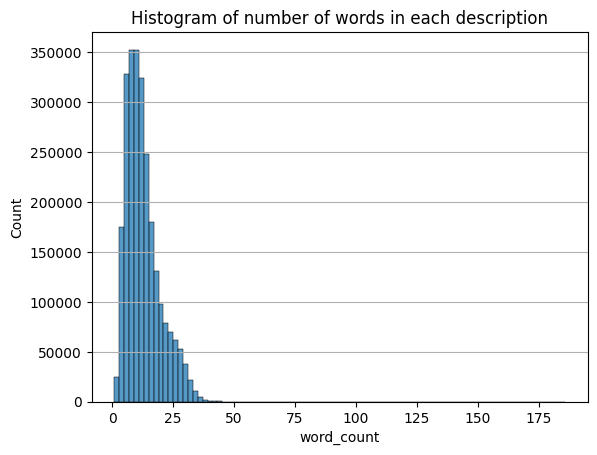

Maximum number of words: 186
Minimum number of words: 1
Mean number of words: 13
Standard deviation of number of words: 7 

Entry with the minimum amount of words:
 description                b06xpp7wjz
id                                  0
word_count                          1
full           electronics_smart-home
main                      electronics
sub                              None
subsub                           None
bottom                     smart-home
Name: 799, dtype: object


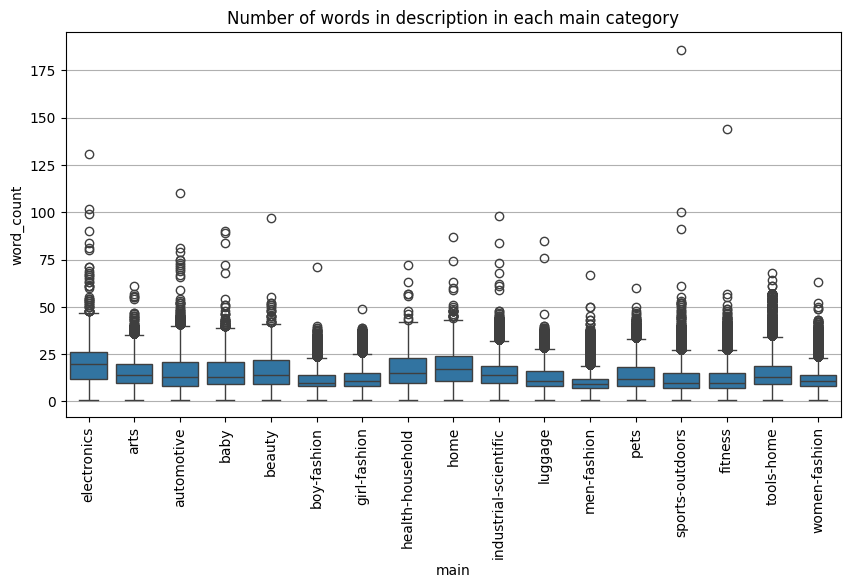

In [91]:
sns.histplot(amz.df, x='word_count', binwidth=2)
plt.grid(axis='y')
plt.title('Histogram of number of words in each description')
plt.show()
print('Maximum number of words:', max(amz.df['word_count']))
print('Minimum number of words:', min(amz.df['word_count']))
print('Mean number of words:', round(np.mean(amz.df['word_count'])))
print('Standard deviation of number of words:', round(np.std(amz.df['word_count'])), '\n')
print('Entry with the minimum amount of words:\n', amz.df.iloc[np.argmin(amz.df['word_count'])])

fig = plt.figure(figsize=(10, 5))
sns.boxplot(amz.df, x='main', y='word_count')
plt.xticks(rotation=90, fontsize = 10) 
plt.title('Number of words in description in each main category')
plt.grid(axis='y')
plt.show()


Below, first the number of items in each main category is plotted. Then then number of items in each detailed category is plotted. 

Women's fashion is the largest main category with over 500,000 items and health household has the least amount of items. 

In detailed categories, fan shop is extremely large category (73,000 items) compared to the others and some categories have only 6 items. Learning from very small categories may not work well.

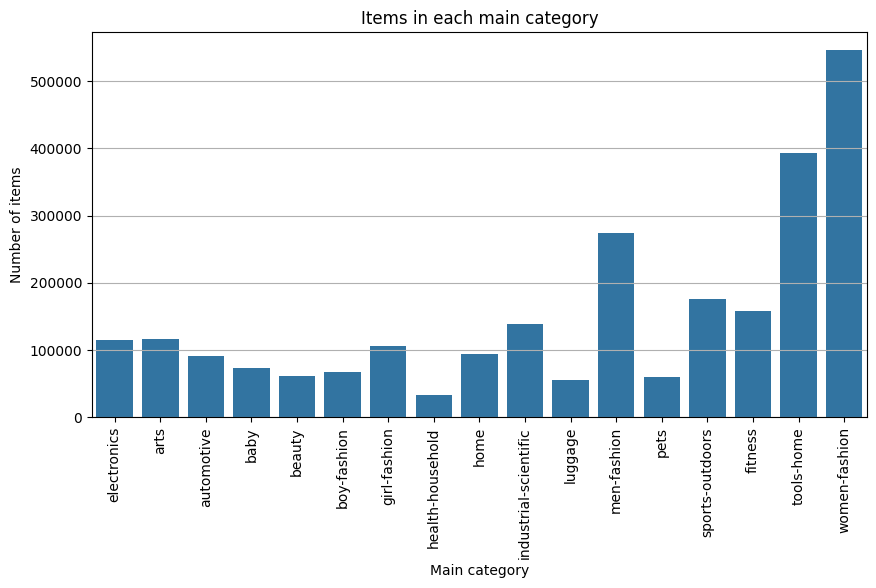

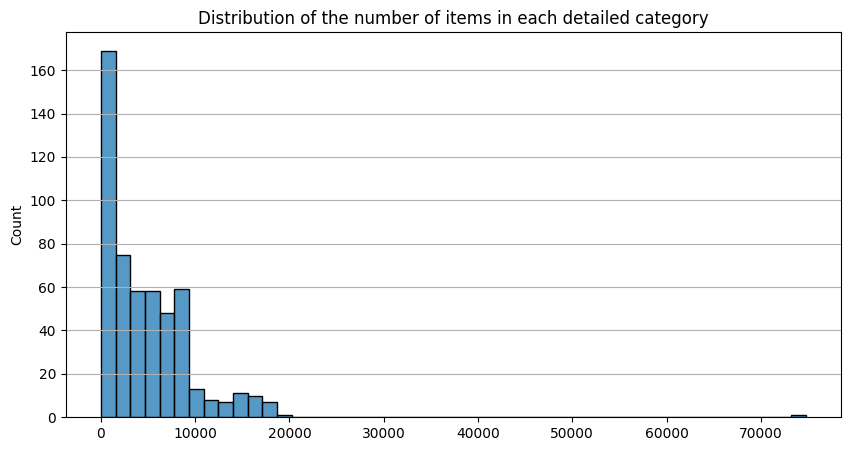

Maximum number of items: 74742
Minimum number of items: 6
Mean number of items: 4864
Standard deviation of number of items: 5259 

Item count of the five largest categories:
 full
sports-outdoors_fan-shop         74742
women-fashion_jewelry_body       18876
girl-fashion_jewelry_earrings    18448
men-fashion_access_sunglasses    18337
men-fashion_watches              18282
dtype: int64 

Item count of the five smallest categories:
 full
sports-outdoors_recreation_water-sports_clothing     6
fitness_running_gps                                  7
tools-home_appliances_dishwasher                    15
boy-fashion_jewelry_tie-clips                       30
tools-home_appliances_ranges                        30
dtype: int64


In [92]:
fig = plt.figure(figsize=(10, 5))
sns.countplot(amz.df, x='main', stat='count')
plt.title('Items in each main category')
plt.xlabel('Main category')
plt.ylabel('Number of items')
plt.xticks(rotation=90, fontsize = 10)
plt.grid(axis='y')
plt.show()

fig = plt.figure(figsize=(10, 5))
sizes = amz.df.groupby('full').size()
sns.histplot(sizes)
plt.title('Distribution of the number of items in each detailed category')
plt.grid(axis='y')
plt.show()

print('Maximum number of items:', max(sizes))
print('Minimum number of items:', min(sizes))
print('Mean number of items:', round(np.mean(sizes)))
print('Standard deviation of number of items:', round(np.std(sizes)), '\n')

print('Item count of the five largest categories:\n', sizes.sort_values(ascending=False)[0:5], '\n')
print('Item count of the five smallest categories:\n', sizes.sort_values(ascending=True)[0:5])


In [ ]:
# raw_train_ds = keras.utils.text_dataset_from_directory(
#     "aclImdb/train",
#     batch_size=batch_size,
#     validation_split=0.2,
#     subset="training",
#     seed=1337,
# )
# raw_val_ds = keras.utils.text_dataset_from_directory(
#     "aclImdb/train",
#     batch_size=batch_size,
#     validation_split=0.2,
#     subset="validation",
#     seed=1337,
# )
# raw_test_ds = keras.utils.text_dataset_from_directory(
#     "aclImdb/test", batch_size=batch_size
# )

# print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
# print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
# print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

In [94]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    amz.df,
    test_size=test_split,
    stratify=amz.df["main"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 2298150
Number of rows in validation set: 127676
Number of rows in test set: 127675


In [96]:
# Model constants.
batch_size = 32
max_features = 20000
embedding_dim = 128
sequence_length = 200

In [97]:
# https://keras.io/examples/nlp/multi_label_classification/
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["main"].values)
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["description"].values, labels)
    )
    # label_binarized = lookup(labels).numpy()
    # dataset = tf.data.Dataset.from_tensor_slices(
    #     (dataframe["summaries"].values, label_binarized)
    # )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [98]:
train_ds = make_dataset(train_df, is_train=True)
val_ds = make_dataset(val_df, is_train=False)
test_ds = make_dataset(test_df, is_train=False)

In [99]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(33):
        print(label_batch.numpy()[i], '\t\t', text_batch.numpy()[i])


b'industrial-scientific' 		 b'superwhole 2 male 2 male hex nipple stainless steel 304 threaded pipe fitting npt'
b'women-fashion' 		 b"lily parker women' mid rise distressed denim pants skinny jeans"
b'pets' 		 b'iris ellipse cat litter box'
b'tools-home' 		 b'armacost lighting 213812 gimball recessed led puck light, matte white'
b'women-fashion' 		 b'bee happy sweatshirt women cute funny long sleeve tee tops honey bee graphic casual shirt pullover'
b'women-fashion' 		 b'gem stone king 925 sterling silver green peridot heart shape mothers day mom ring (0.52 cttw, gemstone birthstone, available 5,6,7,8,9)'
b'women-fashion' 		 b'cable knit arm warmers with thumb holes long fingerless gloves mittens for girls'
b'home' 		 b'kitchpower kn256ww 6 wire whip attachment for kitchenaid 6 quart bowl lift stand mixer accessory replacement, egg cream stirrer, cakes mayonnaise stainless steel whisk'
b'sports-outdoors' 		 b'collegiate licensed texas tech ladies fashion watch'
b'women-fashion' 		 b'ch

In [ ]:
# def vectorize_text(text, label):
#     text = tf.expand_dims(text, -1)
#     return vectorize_layer(text), label


# # Vectorize the data.
# train_ds = raw_train_ds.map(vectorize_text)
# val_ds = raw_val_ds.map(vectorize_text)
# test_ds = raw_test_ds.map(vectorize_text)

# # Do async prefetching / buffering of the data for best performance on GPU.
# train_ds = train_ds.cache().prefetch(buffer_size=10)
# val_ds = val_ds.cache().prefetch(buffer_size=10)
# test_ds = test_ds.cache().prefetch(buffer_size=10)

# Model

Source: https://keras.io/examples/nlp/text_classification_from_scratch/

In [100]:
# A integer input for vocab indices.
inputs = keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(17, activation="softmax", name="predictions")(x)

model = keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, None, 128)      │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, None, 128)      │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,808,337 (10.71 MB)

 Trainable params: 2,808,337 (10.71 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
epochs = 5

# Fit the model using the train and test datasets.
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("functional_6_1/Cast:0", shape=(None,), dtype=int64). Expected shape (None, None), but input has incompatible shape (None,)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None,), dtype=string)
  • training=True
  • mask=None

### Tokenization


TF-IDF is used to convert the text data to numerical representation in matrix format. 

Acronym TF-IDF comes from Term Frequency, Inverse Document Frequency. The first part, Term Frequency, tells how many times a certain word is found in the text. The second part, inverse of Document Frequency, divides the first part by how many documents contain the word. The division lowers the score for common words that appear often, like 'the', 'of', etc. 

Bag of words and TF-IDF should be good choices for the text in descriptions since they usually are just a list of keywords that do not necessary form meaningful sentences.

Below a few categories (for example 7) are randomly chosen for the models. There are two ways to choose the data. Either by the main category or by detailed category. Based on testing, categorizing main categories is challenging, probably due to wide range of items in each main category. Clustering the items into detailed categories is shown in this work. 

Vastly different amount of items in different categories caused extracted keywords to spill into wrong categories. For example, in one case having a modeling set including women's fashion with 20x items than the smallest category caused the word 'leggings' to spill into three extracted categories (tennis gear and industrial equipment). For that reason, the code below picks equal amount of items from each category. NMF and K-means clustering should be able to tolerate differences in category sizes but over 10x difference seemed to be too much. 

In [119]:
import random
number_of_categories = 7

main_category = True
mask = []
counts_train = []
if main_category:
    chosen_categories = random.sample(list(pd.unique(amz.df_cat['main'])), number_of_categories)
    for index, cat in enumerate(chosen_categories):
        m = amz.df['main'] == cat
        counts_train.append(sum(m))
        mask.append(m)
    amount = min(counts_train)
    idx_all = []
    for index, cat in enumerate(chosen_categories):
        m = amz.df['main'] == cat
        idx_all.append(np.where(m)[0][0:amount])
        
    idx_all = np.array(idx_all).flatten()
    X_train = amz.df['description'].iloc[idx_all]
    y_train = amz.df['main'].iloc[idx_all]
else:
    chosen_categories = amz.df_cat.sample(number_of_categories, random_state=25)
    for index, cat in chosen_categories.iterrows():
        m = amz.df['full'] == cat['full']
        counts_train.append(sum(m))
        mask.append(m)
    amount = min(counts_train)
    idx_all = []
    for index, cat in chosen_categories.iterrows():
        m = amz.df['full'] == cat['full']
        idx_all.append(np.where(m)[0][0:amount])

    idx_all = np.array(idx_all).flatten()
    X_train = amz.df['description'].iloc[idx_all]
    y_train = amz.df['full'].iloc[idx_all]

print(X_train.info())
print(y_train.info())
y_train = np.array([s.replace('-',' ').replace('_',' - ') for s in y_train])
categories_train = pd.unique(y_train)
# categories_train = [s.replace('-',' ').replace('_',' - ') for s in categories_train]
print('\n' + '\n'.join([cat+': '+str(cnt) for cat, cnt in zip(categories_train, counts_train)]))


<class 'pandas.core.series.Series'>
Index: 471996 entries, 2079791 to 207308
Series name: description
Non-Null Count   Dtype 
--------------   ----- 
471996 non-null  object
dtypes: object(1)
memory usage: 7.2+ MB
None
<class 'pandas.core.series.Series'>
Index: 471996 entries, 2079791 to 207308
Series name: main
Non-Null Count   Dtype 
--------------   ----- 
471996 non-null  object
dtypes: object(1)
memory usage: 7.2+ MB
None

tools home: 393049
sports outdoors: 175390
home: 93186
girl fashion: 106459
boy fashion: 67428
women fashion: 545838
automotive: 90845


Based on testing a few TFID parameters (some of them shown in the code below), the following parameters were chosen:
* Sublinear Term Frequency (TF) scaling
* Ignore terms that have a document frequency strictly higher 95%
* Ignore terms that have a document frequency strictly lower 5 words
* L2 norm
* Latin-1 encoding and English stop words
* Only single words considered

In [120]:
doe = 2
if doe == 1:
    my_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=5, 
                                    norm='l2', encoding='latin-1', ngram_range=(1, 2), 
                                    stop_words="english", max_features=10000)
elif doe == 2:
    my_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=5, 
                                    norm='l2', encoding='latin-1', ngram_range=(1, 1), 
                                    stop_words="english", max_features=10000, strip_accents='ascii')
elif doe == 3:
    my_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=2, 
                                    norm='l2', encoding='latin-1', ngram_range=(1, 1), 
                                    stop_words="english", max_features=10000)

mat = my_vectorizer.fit_transform(X_train)
# mat.shape


Inspecting the feature names printed below, shows that the vectorizer does well extracting the key words. All the words are proper english words, there is no punctuation, number, partial words, etc.

In [121]:
print('Shape of the matrix:', mat.shape)
ftr_names = my_vectorizer.get_feature_names_out()
print('Length of ftr_names:',len(ftr_names))
print('Sample of the feature names:\n', ftr_names[100:200])

Shape of the matrix: (471996, 10000)
Length of ftr_names: 10000
Sample of the feature names:
 ['11mm' '11w' '11x14' '11x17' '12' '120' '1200' '12000' '12000lm' '120149'
 '120v' '120vac' '120w' '122' '125' '1250' '125cc' '128' '12h' '12in'
 '12inch' '12m' '12mm' '12oz' '12pcs' '12pk' '12t' '12v' '12w' '12x'
 '12x12' '12x16' '12x18' '12x24' '12y' '12yrs' '13' '130' '1300' '130v'
 '132' '135' '136' '138' '139' '13mm' '13th' '13w' '14' '140' '1400' '142'
 '144' '145' '14k' '14mm' '14oz' '14w' '14y' '15' '150' '1500' '1500w'
 '150cc' '150mm' '150w' '152' '158' '15a' '15cm' '15ft' '15mm' '15oz'
 '15pcs' '15w' '16' '160' '1600' '16100' '164' '165' '168' '16ft' '16in'
 '16mm' '16oz' '16pcs' '16th' '16w' '16x16' '16x20' '16x24' '16x24x3' '17'
 '170' '174' '175' '17mm' '18' '180']


## Models ##
In this chapter, the learning models are built. First some of the helper functions are defined. The the non-Negative Matrix Factorization model is built and tested. Then k-Means model and lastly the supervised models for benchmarking.

### Helper functions ###

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, RocCurveDisplay, roc_auc_score

class calc_metrics:
    def __init__(self, y_test, y_pred):
        self.confusion_matrix = None
        self.recall = None
        self.f1_score = None
        self.precision = None
        self.recall = None
        self.FNR = None

        self.get_metrics(y_test, y_pred)

    def get_metrics(self, y_test, y_pred):
        conf_mat = confusion_matrix(y_test, y_pred)
        self.confusion_matrix = pd.DataFrame(conf_mat)
        self.accuracy = accuracy_score(y_test, y_pred)
        print('Accuracy:', round(self.accuracy, 3))
        print('Confusion matrix:')
        disp = ConfusionMatrixDisplay(conf_mat)
        disp.plot()
        plt.show()

#### Non-negative Matrix Factorization
A few sets of parameters for NMF were evaluated and the following parameters gave the best performance. However, the differences were small, in order of a few %-points in accuracy. 

* Multiplicative Update solver
* Nndsvda (NNDSVD with zeros filled with the average of X) initializion procedure 
* Beta loss: kullback-leibler
* Alpha W/H: 0.00005

In [123]:
doe = 2
if doe == 1:
    myNMF = NMF(n_components=number_of_categories, solver='cd', beta_loss='frobenius', 
                alpha_W=0.0001, alpha_H='same')
elif doe == 2:
    myNMF = NMF(n_components=number_of_categories, random_state=123, init='nndsvda', 
                solver='mu', beta_loss="kullback-leibler", alpha_W=0.00005, alpha_H=0.00005, l1_ratio=0)
elif doe == 3:
    myNMF = NMF(n_components=number_of_categories)
elif doe == 4:
    myNMF = NMF(n_components=number_of_categories, solver='cd', init='nndsvd', 
                beta_loss='frobenius',alpha_W=0.0001, alpha_H='same')

W = myNMF.fit_transform(mat)
H = myNMF.components_

A few checks on the W and H matrices in the code below. 

The 'short' dimension of both matrices matches the number of categories. The H matrix scores the most prevalent words and the W matrix scores the category for each item.   

In [126]:
print('Shape of the matrix:', mat.shape)
print('Shape of W:', W.shape)
print('The first row of W:', W[0,:])
print('Shape of H:', H.shape)
print('The first column of H:', H[:,0])

Shape of the matrix: (471996, 10000)
Shape of W: (471996, 7)
The first row of W: [7.74427253e-103 3.03867797e-003 3.13311172e-002 8.72806252e-089
 3.82579596e-148 6.19598285e-153 3.29304531e-044]
Shape of H: (7, 10000)
The first column of H: [0.         0.         0.11363824 0.         0.         0.
 0.        ]


In [127]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

def plot_top_words(H, feature_names, n_top_words):
    print('Top words in the H-matrix:')
    for topic_idx, topic in enumerate(H):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        print(str(topic_idx) + ':', top_features)

print('Categories in the data set:\n' + '\n'.join(categories_train) + '\n')
plot_top_words(H, ftr_names, 10)


Categories in the data set:
tools home
sports outdoors
home
girl fashion
boy fashion
women fashion
automotive

Top words in the H-matrix:
0: ['long' 'set' 'toddler' 'short' 'little' 'sleeve' 'shirt' 'big' 'girls'
 'boys']
1: ['case' 'square' 'women' 'inch' 'pack' 'wallet' 'leather' 'black' 'holder'
 'sunglasses']
2: ['bulb' 'inch' 'replacement' 'lights' 'white' 'kit' 'air' 'pack' 'led'
 'light']
3: ['birthday' 'decor' 'floral' 'girl' 'wedding' 'flower' 'christmas' 'party'
 'girls' 'dress']
4: ['steel' 'pendant' 'chain' 'charm' 'stainless' 'gift' 'jewelry' 'necklace'
 'silver' 'bracelet']
5: ['logo' 'size' 'university' 'wincraft' 'state' 'team' 'flag' 'new' 'nfl'
 'ncaa']
6: ['sun' 'gloves' 'beanie' 'kids' 'winter' 'knit' 'cap' 'scarf' 'women'
 'hat']


Looking at the lists of top the top words, it should not be hard to figure out the category for each index. However, this work can be done programatically. The code below permutes all index combinations to find the best label order based on the accuracy metric.

Like mentioned in the beginning, the complexity of this method increases sharply with increasing number of categories. Only up to 10 categories is a reasonble number for this method. 

In [128]:
# The label_permute_compare -function below was adapted from my Week 2 peer review.
import itertools
from sklearn.metrics import ConfusionMatrixDisplay
import random


def label_permute_compare(ytdf,yp,subset=1):
    # your code here
    if subset > 1:
        indices = random.sample(range(len(yp)), int(subset * len(yp)))
        ypp = yp[indices]
        ytdfp = ytdf.iloc[indices]
    else:
        ypp = yp
        ytdfp = ytdf
    labels = pd.unique(ytdf)
    best_accuracy = 0
    best_labelorder = []
    # ytdf: from str to int
    labels_lst = list(labels)
    yt_vals = np.array([labels_lst.index(yt) for yt in list(ytdfp)])
    i = 0
    for labelorder in itertools.permutations(np.unique(ypp)):
        yp_labels = [labelorder[y] for y in ypp]
        accuracy = sum(yt_vals == yp_labels)
        i=i+1
        if accuracy > best_accuracy:
            # print(i, ' - ', best_accuracy / len(yp_labels), end='\r')
            best_accuracy = accuracy
            best_labelorder = labelorder
    # print()
    best_accuracy = best_accuracy / len(yp_labels)
    return best_labelorder, best_accuracy

def reorder_prediction(yp, label_order):
    # Remap the predicted labels
    ypp = [label_order[y] for y in yp]
    return ypp

def inspect(item, yp, X_train, y_train):
    print('Index:', item)
    print('Predicted:\t', categories_train[yp[item:item+1]][0])
    print('Actual:\t\t', y_train[item])
    print('Item description:', X_train.iloc[item])

As can be seen below, the model has some trouble categorizing adhesive sealer items. Otherwise it does a decent job. 

In [129]:
yp = np.argmax(W,axis=1)
print('yprediction length:',len(yp))
label_order, best_accu = label_permute_compare(y_train, yp, 1)
print('\nLabel order:', ' --> '.join([str(lbl) for lbl in label_order]))
print('\nAccuracy:', round(best_accu,4))

ypp = reorder_prediction(yp, label_order)
yp_cat = [categories_train[y] for y in ypp]
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_train, [categories_train[y] for y in ypp], ax=ax, xticks_rotation=90)
plt.show()


yprediction length: 471996


KeyboardInterrupt: 

#### Further improve label mapping by using supervised learning
Supervised learning can be used for label assigment instead of picking the largest value in the W-matrix. Accuracy is slightly better with the Support Vector Machine model used below. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm

W_train_svm, W_test_svm, y_train_svm, y_test_svm = train_test_split(W, y_train, test_size=0.2)

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(W_train_svm, y_train_svm)
# print(W_train_svm.shape)
yhat_test_svm = clf.predict(W_test_svm)
print('Accuracy:', round(accuracy_score(y_test_svm, yhat_test_svm),3))

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test_svm, yhat_test_svm, ax=ax, xticks_rotation=90)
plt.show()

Inspecting a few samples from the incorrect predictions reveals that they are not necessary the most clear descriptions but most of humans should not have trouble categorizing them correctly.

In [112]:
# Check
for item in random.sample(list(np.where(yp_cat != y_train)[0]), 4):
    print('Wrong prediction:')
    inspect(item, ypp, X_train, y_train)
    print()


Wrong prediction:
Index: 12
Predicted:	 sports outdoors - recreation - skates
Actual:		 tools home - hardware - adhesives sealers
Item description: mini hot glue gun sticks (huge bulk pack of 200) clear full size 4 long 0.28 diameter compatible with full size industrial glue guns

Wrong prediction:
Index: 156
Predicted:	 sports outdoors - recreation - skates
Actual:		 tools home - hardware - adhesives sealers
Item description: tapecase 3m 2a804c 4 1500ft clear co extruded protective tape, 4 1500' roll

Wrong prediction:
Index: 324
Predicted:	 sports outdoors - recreation - skates
Actual:		 tools home - hardware - adhesives sealers
Item description: mt mtwill13z william morrisdiaper washi masking tape

Wrong prediction:
Index: 47
Predicted:	 sports outdoors - recreation - skates
Actual:		 tools home - hardware - adhesives sealers
Item description: colorants 3 ounce brick red cement and grout pigment



### K-Means

The number of clusters is known, 7 product categories selected. 

The model has trouble also with adhesive sealers and seems to be biased towards skates category.

Values: [5 4 0 2 3 1 6]
Length of labels: 4235
Five first labels: [5 5 5 5 5 5]

Label order: 0 --> 5 --> 3 --> 4 --> 2 --> 1 --> 6

Accuracy: 0.8571


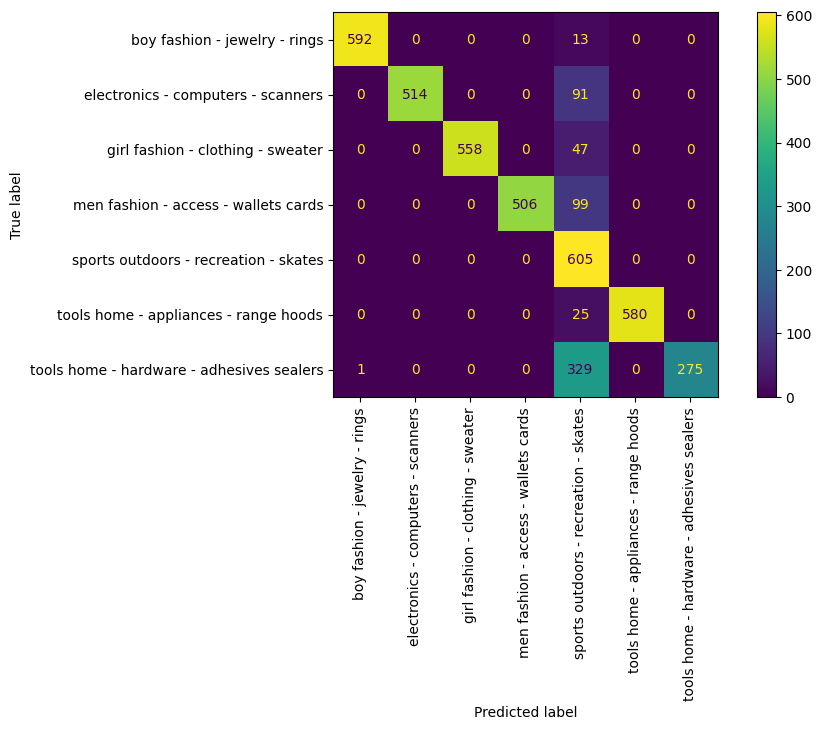

In [113]:
from sklearn.cluster import KMeans
my_kmeans = KMeans(n_clusters=number_of_categories, random_state=12, init='random', n_init=100, max_iter=3000, algorithm='lloyd').fit(mat)
# my_kmeans = KMeans(n_clusters=number_of_categories, random_state=124).fit(mat)
print('Values:', pd.unique(my_kmeans.labels_))
print('Length of labels:', len(my_kmeans.labels_))
print('Five first labels:', my_kmeans.labels_[0:6])

label_order_k, best_accu_k = label_permute_compare(y_train, my_kmeans.labels_, 1)
print('\nLabel order:', ' --> '.join([str(lbl) for lbl in label_order_k]))
print('\nAccuracy:', round(best_accu_k,4))

ypp_k = reorder_prediction(my_kmeans.labels_, label_order_k)
fig, ax = plt.subplots(figsize=(10, 5))
yp_cat_k = [categories_train[y] for y in ypp_k]
ConfusionMatrixDisplay.from_predictions(y_train, yp_cat_k, ax=ax, xticks_rotation=90)
plt.show()

Similarly as with NMF, the incorrect predictions reveal that most of humans should not have trouble categorizing them correctly.

In [114]:
# Check
for item in random.sample(list(np.where(yp_cat != y_train)[0]), 4):
    print('Wrong prediction:')
    inspect(item, ypp, X_train, y_train)
    print()

Wrong prediction:
Index: 182
Predicted:	 sports outdoors - recreation - skates
Actual:		 tools home - hardware - adhesives sealers
Item description: brixwell 24 rolls, pro blue painters masking tape 0.94 inch 60 yard made in the usa

Wrong prediction:
Index: 162
Predicted:	 sports outdoors - recreation - skates
Actual:		 tools home - hardware - adhesives sealers
Item description: relaxdays aluminium adhesive tape, set of 3, water & heat resistant, repairs, seal, 48 mm wide, 10 long, silver, aluminum, 4.8 9 9 cm

Wrong prediction:
Index: 14
Predicted:	 sports outdoors - recreation - skates
Actual:		 tools home - hardware - adhesives sealers
Item description:  rex ferociously strong duct tape, 1.88 in. 35 yd, 1 roll, dark gunmetal gray (240998), 35 yards

Wrong prediction:
Index: 128
Predicted:	 boy fashion - jewelry - rings
Actual:		 tools home - hardware - adhesives sealers
Item description: vibra tite 567 high temperature retaining compound, 1 liter jug, green



## Comparison with supervised methods

Training and testing split is done in the code below.

In [115]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

print('mat.shape:', mat.shape, '\nY_train.shape:', y_train.shape)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(mat, y_train, test_size=0.2, random_state=123)

mat.shape: (4235, 1347) 
Y_train.shape: (4235,)


#### Random Forest
Random forest, even without grid search for optimizing the hyperparameters, performs very well with always well over 90% accuracy.

Accuracy: 0.985
Confusion matrix:


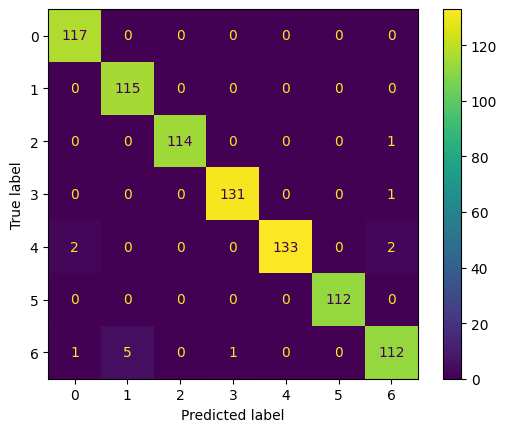

In [ ]:
from sklearn.ensemble import RandomForestClassifier

my_RF = RandomForestClassifier().fit(X_train_clf, y_train_clf) # Create the model
y_hat_RF = my_RF.predict(X_test_clf)

calc_metrics(y_test_clf,  y_hat_RF)
plt.show()

#### Support Vector Machine

Similarly a simple SVM has no trouble categorizing the data with most of the time over 95% accuracy. 

With Radial Basis Function kernel:
Accuracy: 0.992
Confusion matrix:


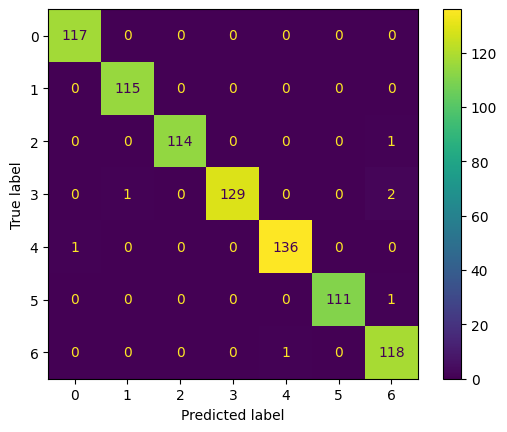

In [117]:
from sklearn.svm import SVC

print('With Radial Basis Function kernel:')
my_SVC = SVC().fit(X_train_clf, y_train_clf) # Create the model
y_hat_SVC = my_SVC.predict(X_test_clf)
calc_metrics(y_test_clf, y_hat_SVC) # calculate metrics
plt.show()


## Discussion and conclusion ##

All the models, NMF, k-means, Random Forest and SVM, worked. The supervised models had consistenlty very good accuracy, over >95% most of the time. 

Non-negative Matrix Factorization performed fairly well, with accuracy typically between 60% and 90%. 

In some cases the K-means model did not perform well, having accuracy of 50%. In those cases it was biased towards certain categories. Overall, k-means had similar or slightly lower accuracy than the NMF. 

Both, NMF and k-means, seemed to have difficulties when there were a lot of items in the data set. With smaller data sets they perfomed at the same level as the supervised models. Supervised models perfomed well regardless of the number of items in the data set. 

### Training time ###

This data set is fairly large so just loading and cleaning the data takes a few minutes. 

#### Detailed categories
Clustering less than 10 detailed categories is fairly fast. Most of the steps taking less than a few seconds on a laptop. 

If more than 10 categories are chosen, model creation is still reasonable but label assignment for model verification using brute-force permutation becomes too long. 

#### Main categories
Main categories have much more items so overall data handling and model building time is much longer. 

### Additional improvements
The models can be improvement by further cleaning the description texts. For example, removing digits often leaves the characters of part numbers intact. A better way would be removing the words with digits in them. Also, even though most of the units were removed, such as 'mm', there still seems to be some left in the data. 

More filtering of the data could also help. Dropping the categories with only a handful of items can help (for example less than 100 items).  